# **PRÉ-PROCESSAMENTO**

#### Importação de dados e bibliotecas

In [41]:
# Data Handling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-Processing
from sklearn.preprocessing import StandardScaler
from prince import MCA

plt.style.use('Solarize_Light2')

In [42]:
df = pd.read_csv(filepath_or_buffer="../data/train.csv")
df.drop(columns="Id", inplace=True)

qualitative_nominal: list[str] = [
    "MSSubClass","MSZoning","Street","Alley","Neighborhood","Condition1","Condition2","BldgType","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType","Foundation","Heating","CentralAir","Electrical","GarageType","MiscFeature","SaleType","SaleCondition"
]
qualitative_ordinal: list[str] = [
    "LotShape","LandContour","Utilities","LotConfig","LandSlope","HouseStyle","OverallQual","OverallCond","ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC","KitchenQual","Functional","FireplaceQu","GarageFinish","GarageQual","GarageCond","PavedDrive","PoolQC","Fence",
]
date: list[str] = [
    "YearBuilt","YearRemodAdd","GarageYrBlt","YrSold"
]

In [43]:
df.drop(columns=qualitative_nominal, inplace=True)

### DADOS FALTANTES

Text(0, 0.5, 'Dados Faltantes (%)')

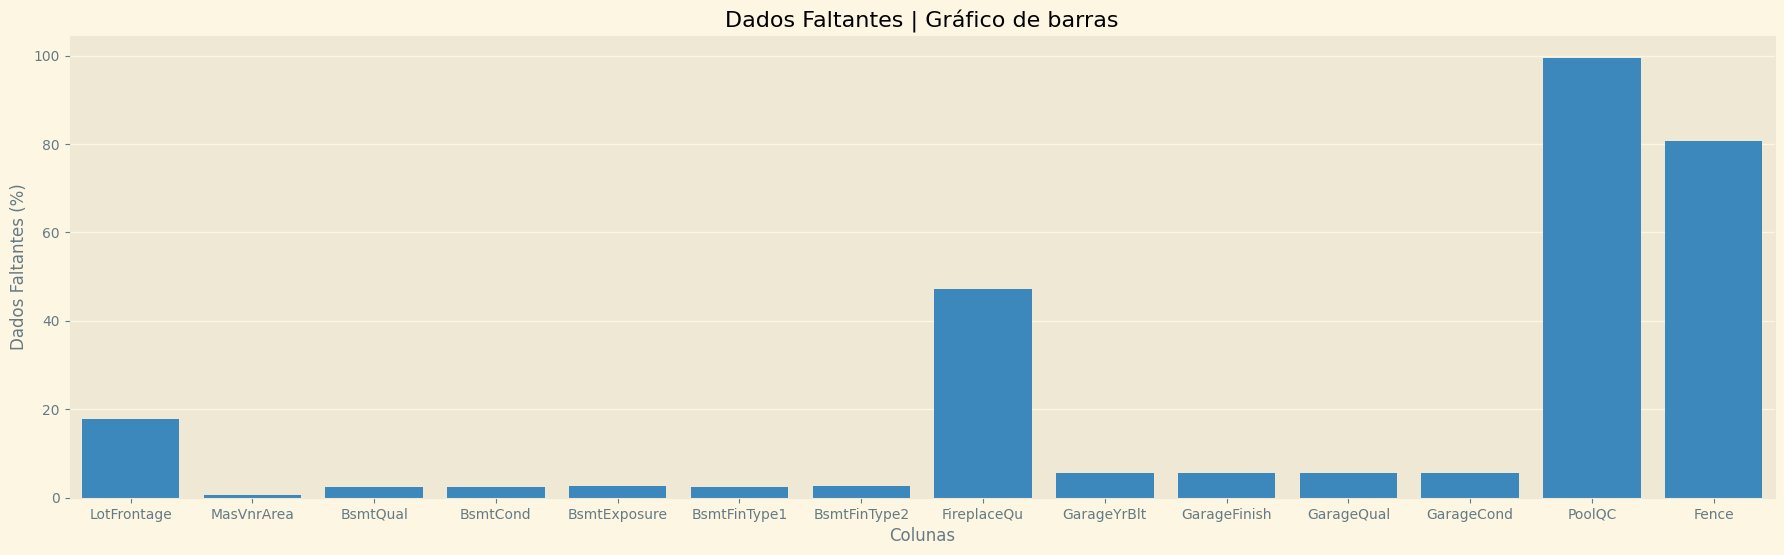

In [44]:
plt.figure(figsize=(22,6))
sns.barplot(
    x=df.isnull().sum()[(df.isnull().sum() > 0)].index,
    y=(df.isnull().sum()[(df.isnull().sum() > 0)] / df.shape[0]) * 100
)
plt.title("Dados Faltantes | Gráfico de barras")
plt.xlabel("Colunas")
plt.ylabel("Dados Faltantes (%)")

In [45]:
# Droping columns with more than 20% of missing data
threshold = df.shape[0] * (20/100)
df.drop(
    columns=df.isnull().sum()[
        (df.isnull().sum() > threshold)
    ].index,
    inplace=True
)

In [46]:
# Droping qualitative columns with missing data
to_drop = []
for col in df.isnull().sum()[(df.isnull().sum() > 0)].index.to_list():
    if col in qualitative_nominal:
        to_drop.append(col)
    elif col in qualitative_ordinal:
        to_drop.append(col)
    elif col in date:
        to_drop.append(col)

df.drop(columns=to_drop, inplace=True)

In [47]:
# Filling quantitative columns with mean in missing data samples
for col in df.isnull().sum()[(df.isnull().sum() > 0)].index.to_list():
    df.fillna(value={col: df[col].mean()}, inplace=True)

In [48]:
# Checking if have a missing data
df.isnull().sum()[(df.isnull().sum() > 0)]

Series([], dtype: int64)

In [49]:
# Updating the qualitative columns
qualitative_ordinal = list(set(qualitative_ordinal) & set(df.columns.to_list()))
date = list(set(date) & set(df.columns.to_list()))

# Deleting aux variables
del threshold
del to_drop
del col

### SPLITING DATA

In [50]:
X = df.drop(['SalePrice'], axis=1)
y = df.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2024)

In [51]:
df_train = X_train.copy()
df_train["SalePrice"] = y_train.to_list()

df_test = X_test.copy()
df_test["SalePrice"] = y_test.to_list()

### FEATURE ENGINEERING

- Criadas novas variáveis derivadas de outras colunas para melhor representar aspectos estruturais das casas, como TotalBathrooms e TotalSF, que agregam áreas e banheiros. Além disso, aplicamos transformações logarítmicas em variáveis com distribuição assimétrica.

- Cria uma nova coluna TotalBathrooms, que representa o total de banheiros na casa. A fórmula considera que um banheiro completo (FullBath) tem peso 1, enquanto um meio banheiro (HalfBath) tem peso 0,5. Isso permite uma única métrica para o total de banheiros, que facilita a análise.

- Cria a coluna TotalSF, representando a área total da casa em pés quadrados. Soma TotalBsmtSF (área do porão), 1stFlrSF (área do primeiro andar) e 2ndFlrSF (área do segundo andar), consolidando todas as áreas para criar uma métrica abrangente de espaço.

- Aplica uma transformação logarítmica à variável GrLivArea (área habitável acima do solo) usando np.log1p, que calcula o logaritmo natural de (1 + valor). A transformação logarítmica reduz a assimetria da distribuição de GrLivArea, tornando-a mais parecida com uma distribuição normal. Isso beneficia muitos modelos de machine learning.

- Aplica a mesma transformação logarítmica à variável alvo SalePrice (preço de venda da casa). Essa transformação ajuda a reduzir a influência de valores de preço extremos, beneficiando modelos que assumem uma distribuição aproximadamente normal da variável alvo.

In [52]:
df_train['TotalBathrooms'] = df_train['FullBath'] + (0.5 * df_train['HalfBath'])
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_train['GrLivArea'] = np.log1p(df_train['GrLivArea'])
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

df_test['TotalBathrooms'] = df_test['FullBath'] + (0.5 * df_test['HalfBath'])
df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']
df_test['GrLivArea'] = np.log1p(df_test['GrLivArea'])
df_test['SalePrice'] = np.log1p(df_test['SalePrice'])

### LIMPEZA DE DADOS

In [53]:
df_quantitative_train = df_train.drop(
    columns=qualitative_ordinal
).drop(columns=date)

df_quantitative_test = df_test.drop(
    columns=qualitative_ordinal
).drop(columns=date)



df_qualitative_train = df_train.drop(
    columns=df_quantitative_train.columns
).drop(columns=date)

df_qualitative_test = df_test.drop(
    columns=df_quantitative_test.columns
).drop(columns=date)

In [54]:
to_drop = df_quantitative_train.corr().abs()["SalePrice"][
    (df_quantitative_train.corr().abs()["SalePrice"] < 0.4)
].index.to_list()

df_quantitative_train.drop(columns=to_drop, inplace=True)
df_quantitative_test.drop(columns=to_drop, inplace=True)

### NORMALIZAÇÃO

In [55]:
scaler = StandardScaler().fit(df_quantitative_train)
df_quantitative_train_ = scaler.transform(df_quantitative_train)
df_quantitative_test_ = scaler.transform(df_quantitative_test)

df_quantitative_train = pd.DataFrame(
    data=df_quantitative_train_,
    columns=df_quantitative_train.columns
)
df_quantitative_train['SalePrice']=df_train['SalePrice'].tolist()

df_quantitative_test = pd.DataFrame(
    data=df_quantitative_test_,
    columns=df_quantitative_test.columns
)
df_quantitative_test['SalePrice']=df_test['SalePrice'].tolist()

In [56]:
display(df_quantitative_train.head(n=3))
display(df.head(n=3))

,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,SalePrice,TotalBathrooms,TotalSF
0,0.273882,0.086154,-0.162418,-0.774437,-1.019676,-0.311843,-0.957037,-1.020011,-0.983024,11.813037,-1.189393,-0.444052
1,-0.586700,0.318481,0.097458,-0.512125,2.605839,-0.921949,-0.957037,-2.360139,-2.200746,12.095147,1.953619,-0.199737
2,-0.176356,0.118042,-0.063054,-0.671374,0.793082,-0.921949,0.572127,0.320116,0.379889,12.078245,0.382113,-0.380578


,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,SalePrice,TotalBathrooms,TotalSF
0,1.031878,0.518920,0.354787,1.556092,0.793082,1.518473,0.572127,0.320116,-0.036947,12.468441,1.167866,1.363164
1,1.066073,0.325314,0.133127,1.679381,0.793082,1.518473,0.572127,1.660243,1.176092,12.577640,1.167866,1.384721
2,-0.586700,-0.578940,-0.519112,0.296609,-1.019676,-0.921949,2.101291,-1.020011,-1.076695,11.798112,-1.189393,-0.218899


### EXPORT

In [59]:
display(df_qualitative_train.head(n=3))
display(df_quantitative_train.head(n=3))

,LotShape,LandContour,Utilities,LotConfig,LandSlope,HouseStyle,OverallQual,OverallCond,ExterQual,ExterCond,HeatingQC,KitchenQual,Functional,PavedDrive
967,IR1,Lvl,AllPub,Inside,Gtl,1Story,5,7,TA,TA,TA,TA,Typ,Y
738,Reg,Lvl,AllPub,Inside,Gtl,1Story,5,5,TA,TA,TA,TA,Typ,Y
695,IR1,Lvl,AllPub,Inside,Gtl,1Story,6,6,TA,TA,Gd,Gd,Typ,Y


,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,SalePrice,TotalBathrooms,TotalSF
0,0.273882,0.086154,-0.162418,-0.774437,-1.019676,-0.311843,-0.957037,-1.020011,-0.983024,11.813037,-1.189393,-0.444052
1,-0.586700,0.318481,0.097458,-0.512125,2.605839,-0.921949,-0.957037,-2.360139,-2.200746,12.095147,1.953619,-0.199737
2,-0.176356,0.118042,-0.063054,-0.671374,0.793082,-0.921949,0.572127,0.320116,0.379889,12.078245,0.382113,-0.380578


In [60]:
df_train = pd.concat(objs=[df_qualitative_train, df_quantitative_train])
df_test = pd.concat(objs=[df_qualitative_test, df_quantitative_test])

display(df_train.head(n=3))
display(df_test.head(n=3))

,LotShape,LandContour,Utilities,LotConfig,LandSlope,HouseStyle,OverallQual,OverallCond,ExterQual,ExterCond,...,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,SalePrice,TotalBathrooms,TotalSF
967,IR1,Lvl,AllPub,Inside,Gtl,1Story,5.0,7.0,TA,TA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
738,Reg,Lvl,AllPub,Inside,Gtl,1Story,5.0,5.0,TA,TA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
695,IR1,Lvl,AllPub,Inside,Gtl,1Story,6.0,6.0,TA,TA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,LotShape,LandContour,Utilities,LotConfig,LandSlope,HouseStyle,OverallQual,OverallCond,ExterQual,ExterCond,...,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,SalePrice,TotalBathrooms,TotalSF
85,Reg,Lvl,AllPub,Corner,Gtl,2Story,8.0,5.0,Gd,TA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,IR1,Lvl,AllPub,Inside,Gtl,2Story,7.0,5.0,Gd,TA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,Reg,Lvl,AllPub,Inside,Gtl,1.5Fin,6.0,7.0,TA,TA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
#dataset_train.to_csv(path_or_buf="../data/train.csv")
#dataset_test.to_csv(path_or_buf="../data/test.csv")